# Bayesian-CNN Demo

This notebook demonstrates how we can use bayesian cnn to quantify uncertainty in image classifiction task.

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

In [2]:
(images_train, label), (images_test, label_test) = mnist.load_data()
images_train = images_train[...,np.newaxis] / 255.0
images_test = images_test[...,np.newaxis] / 255.0

# here we remove number 6-9 from training set, 
# but they are still in the test set. 
images_train = images_train[label<6]
label = label[label<6]
label = np.eye(10)[label]

print (label.shape, images_train.shape)

(36017, 10) (36017, 28, 28, 1)


In [5]:
# bnn model
kernel_divergence_fn = lambda q, p, _: tfp.distributions.kl_divergence(q, p) / images_train.shape[0]
def conv_v(filters, kernel_size, strides, atv, padding):
    return  tfp.layers.Convolution2DFlipout(filters,
                                             kernel_size=kernel_size,
                                             strides = strides,
                                             activation = atv,
                                             padding= padding,
                                             kernel_divergence_fn=kernel_divergence_fn)


def create_model():
    inp = tf.keras.Input(shape=(28, 28, 1))
    
    x = conv_v(16, 3, 2, 'relu','same' )(inp)
    x = conv_v(32, 3, 2,'relu','same')(x)
    x = conv_v(64, 7, 1,'relu','valid')(x)
    x = conv_v(10, 1, 1,'softmax','valid')(x)
    x = tf.keras.layers.Flatten()(x)
    
    model = tf.keras.Model(inp, x)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    model.summary()
    return model 

model = create_model()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_flipout_4 (Conv2DFlip (None, 14, 14, 16)        304       
_________________________________________________________________
conv2d_flipout_5 (Conv2DFlip (None, 7, 7, 32)          9248      
_________________________________________________________________
conv2d_flipout_6 (Conv2DFlip (None, 1, 1, 64)          200768    
_________________________________________________________________
conv2d_flipout_7 (Conv2DFlip (None, 1, 1, 10)          1290      
_________________________________________________________________
flatten_1 (Flatten)          (None, 10)                0         
Total params: 211,610
Trainable params: 211,610
Non-trainable params: 0
_____________________________________________________

In [6]:
# train and validate
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=5, 
                                                           restore_best_weights=True)
model.fit(images_train, label,
          validation_split=0.1,
          batch_size=512,
          epochs=100, 
          callbacks=[early_stopping_callback])

Epoch 1/100
64/64 [==============================] - 7s 63ms/step - loss: 9.1006 - acc: 0.3457 - val_loss: 7.5526 - val_acc: 0.9062
Epoch 2/100
64/64 [==============================] - 3s 52ms/step - loss: 7.5044 - acc: 0.9111 - val_loss: 7.2688 - val_acc: 0.9547
Epoch 3/100
64/64 [==============================] - 3s 51ms/step - loss: 7.2525 - acc: 0.9474 - val_loss: 7.0808 - val_acc: 0.9675
Epoch 4/100
64/64 [==============================] - 3s 52ms/step - loss: 7.0531 - acc: 0.9640 - val_loss: 6.9147 - val_acc: 0.9722
Epoch 5/100
64/64 [==============================] - 3s 51ms/step - loss: 6.8833 - acc: 0.9706 - val_loss: 6.7599 - val_acc: 0.9770
Epoch 6/100
64/64 [==============================] - 3s 51ms/step - loss: 6.7191 - acc: 0.9755 - val_loss: 6.5972 - val_acc: 0.9814
Epoch 7/100
64/64 [==============================] - 3s 52ms/step - loss: 6.5641 - acc: 0.9783 - val_loss: 6.4480 - val_acc: 0.9817
Epoch 8/100
64/64 [==============================] - 3s 52ms/step - loss: 6.

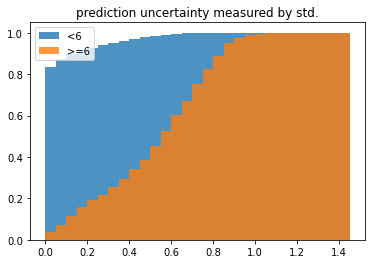

In [7]:
# quantify predictions uncertainty between seen (0-5) and unseen data (6-9)
test_samples = 1000
outputs = [model.predict(images_test[:test_samples])[np.newaxis] for _ in range(50)]
outputs = np.concatenate(outputs, 0)
std = np.sum(np.std(outputs, 0), -1)

plt.hist(std[label_test[:test_samples] < 6], bins=list(np.arange(0, 1.5, 0.05)), label='<6', cumulative=True, alpha=0.8, density=True)    
plt.hist(std[label_test[:test_samples] >= 6], bins=list(np.arange(0, 1.5, 0.05)), label='>=6', cumulative=True, alpha=0.8, density=True)
plt.title('prediction uncertainty measured by std.')
plt.legend()
plt.show()